In [1]:
import numpy as np

#%matplotlib inline
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal
from sklearn import datasets

In [2]:
class EM:
    
    def __init__(self, k = 3, pca_dim = 2):
        self.k = k
        self.pca_dim = pca_dim
        data = np.loadtxt("./data.txt")
        self.features_count = data.shape[-1]
        self.samples_count = data.shape[0]
        
        self.transformed_data = self.PCA(data) 
        self.transformed_data_T = self.transformed_data.T
        self.allow_singular = False
        
        self.eps = np.finfo(float).eps
        
        # param init
        self.coefficient = np.ones(self.k)/self.k #+ np.finfo(float).eps  
        
        self.mean = np.zeros((self.k, self.pca_dim))        
        for pca_dim_iter in range(self.pca_dim):
            self.mean[:, pca_dim_iter] = np.random.choice(self.transformed_data[:, pca_dim_iter], self.k)
           
        self.covar = np.zeros((self.k, self.pca_dim, self.pca_dim))         
        for k_iter in range(self.k):
            self.covar[k_iter] = datasets.make_spd_matrix(self.pca_dim)        
       
        self.p_ik = np.zeros((self.k, self.samples_count))
        for i in range(self.samples_count):
            self.p_ik[:,i] = 1/self.samples_count                    
        
        self.prev_log = self.log_likelihood()
        
    def calculate_probab(self):
        self.p_ik = np.zeros((self.k, self.samples_count))
        
        whole_sum = np.zeros((self.samples_count))
        
        for sample_iter in range(self.samples_count):
            for cluster_iter in range(self.k):
                temp = multivariate_normal.pdf(self.transformed_data[sample_iter], mean=self.mean[cluster_iter], cov=self.covar[cluster_iter],allow_singular=self.allow_singular)
                #print("pdf_output",temp.shape)
                self.p_ik[cluster_iter][sample_iter] = self.coefficient[cluster_iter] * temp
                whole_sum[sample_iter] += self.p_ik[cluster_iter][sample_iter]
                
        #print(self.p_ik)        
        self.p_ik = self.p_ik / whole_sum  
        #print(self.p_ik)
        return self.p_ik 
    
    def covariance_calc(self):
        
        self.covar = np.zeros((self.k, self.pca_dim, self.pca_dim))    
        
        for cluster_iter in range(self.k):             
            for sample_iter in range(self.samples_count):            
                temp = self.transformed_data[sample_iter] - self.mean[cluster_iter]
                self.covar[cluster_iter] += self.p_ik[cluster_iter][sample_iter] * np.outer(temp,temp)
                
            self.covar[cluster_iter] = self.covar[cluster_iter] / np.sum(self.p_ik[cluster_iter])
        
        return self.covar
    
    def mean_calc(self):
        
        self.mean = np.zeros((self.k, self.pca_dim))      
        
        for cluster_iter in range(self.k):            
            for sample_iter in range(self.samples_count):            
                self.mean[cluster_iter] += (self.p_ik[cluster_iter][sample_iter] * self.transformed_data[sample_iter])
                
            self.mean[cluster_iter] = self.mean[cluster_iter] / np.sum(self.p_ik[cluster_iter])
        
        return self.mean
    
    def coefficient_calc(self):
        
        self.coefficient = np.zeros(self.k)      
        
        for cluster_iter in range(self.k):            
            self.coefficient[cluster_iter] = np.sum(self.p_ik[cluster_iter]) / self.samples_count
        
        return self.coefficient
    
    def log_likelihood(self):
        
        log_like = 0.0                
        for sample_iter in range(self.samples_count):
            prob_sum = 0.0            
            for cluster_iter in range(self.k):
                prob_sum += self.coefficient[cluster_iter] * multivariate_normal.pdf(self.transformed_data[sample_iter], mean=self.mean[cluster_iter], cov=self.covar[cluster_iter],allow_singular=self.allow_singular)
            
            log_like += np.log(prob_sum)
                
        return log_like
        
    
    def PCA(self, data):
        features_count = self.features_count
        samples_count = self.samples_count
        mean_array = np.mean(data, axis=0)

        # https://machinelearningmastery.com/calculate-principal-component-analysis-scratch-python/

        variance_matrix = data - mean_array
        covariance_matrix = (1/samples_count) * np.matmul(variance_matrix.T, variance_matrix)
        print("covariance_matrix",covariance_matrix.shape)

        values, vectors = np.linalg.eig(covariance_matrix)
        vectors = vectors[:, values.argsort()[-self.pca_dim:][::-1]]
        print("vectors",vectors.shape)

        PCA = np.dot(data, vectors)
        print("PCA",PCA.shape)
        
        # checking
        B = covariance_matrix.dot(vectors[:, 0])
        print(B[1:10])
        C = vectors[:, 0] * values[0]
        print(C[1:10])

        two_val_PCA = PCA#[0:self.pca_dim]
        print(two_val_PCA.T.shape)

        plt.scatter(PCA[:,0], PCA[:,1], alpha=0.5)
        
        plt.savefig("pca_plot.png") 
        plt.show()
        
        return two_val_PCA
        # dimension (2*1000)

    def E_step(self):
        self.p_ik = self.calculate_probab()
        # print("in_E")

    def M_step(self):
        self.mean = self.mean_calc()
        self.covar = self.covariance_calc()
        self.coefficient = self.coefficient_calc()       
        # print("in_M")
        
    def plot(self, save_fig = False):
        pred_prob = self.predict()
        predictions = pred_prob.argmax(0)
        #print(predictions)
        c0 = np.where(predictions==0)[0]
        c1 = np.where(predictions==1)[0]
        c2 = np.where(predictions==2)[0]
        #print("shape_of_pred",pred_prob.shape,len(c0), len(c1), len(c2))

        plt.scatter(self.transformed_data[c0,0], self.transformed_data[c0,1], alpha=0.5)
        plt.scatter(self.transformed_data[c1,0], self.transformed_data[c1,1], alpha=0.5)
        plt.scatter(self.transformed_data[c2,0], self.transformed_data[c2,1], alpha=0.5)
        
        if save_fig:
            plt.savefig("final_plot.png") 
            
        plt.show()
                
    
    def forward(self, epoch, threshold):
        
        for epoch_iter in range(epoch):
            self.E_step()
            self.M_step()
            cur = self.log_likelihood()
            if (abs(cur - self.prev_log)) < threshold:
                print("ended in epoch",epoch_iter,abs(cur - self.prev_log))
                print("mean",self.mean)
                print("covariance",self.covar)
                print("coefficient",self.coefficient)
                self.plot(save_fig = True)
                break
            else:
                self.prev_log = cur
                
            if (epoch % 5) == 0:
                self.plot()
                
    def predict(self):
            
        pred_p_ik = np.zeros((self.k, self.samples_count))        
        whole_sum = np.zeros((self.samples_count))
        
        for sample_iter in range(self.samples_count):
            for cluster_iter in range(self.k):
                temp = multivariate_normal.pdf(self.transformed_data[sample_iter], mean=self.mean[cluster_iter], cov=self.covar[cluster_iter],allow_singular=self.allow_singular)
                #print("pdf_output",temp.shape)
                pred_p_ik[cluster_iter][sample_iter] = self.coefficient[cluster_iter] * temp
                whole_sum[sample_iter] += pred_p_ik[cluster_iter][sample_iter]
                
        pred_p_ik = pred_p_ik / whole_sum  
        return pred_p_ik 
            


covariance_matrix (100, 100)
vectors (100, 2)
PCA (1000, 2)
[ 3.10718223 -2.7192077  -2.29863144 -0.6436225  -0.99147363 -1.36196002
 -1.07972292 -2.50591031 -2.15553883]
[ 3.10718223 -2.7192077  -2.29863144 -0.6436225  -0.99147363 -1.36196002
 -1.07972292 -2.50591031 -2.15553883]
(2, 1000)


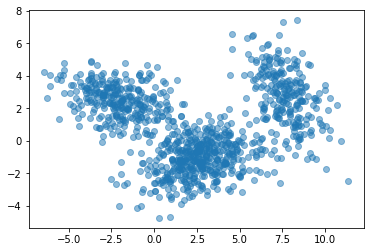

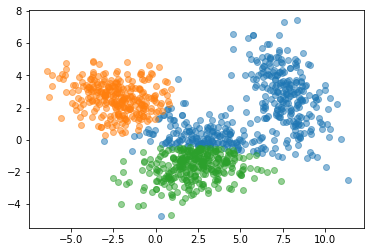

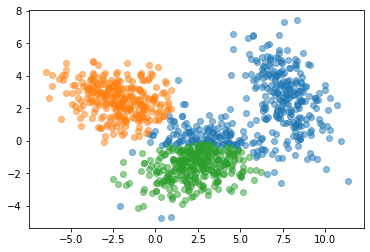

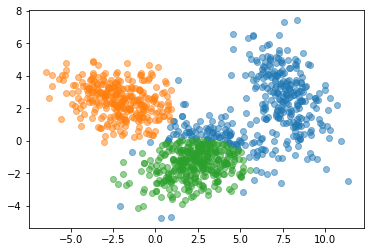

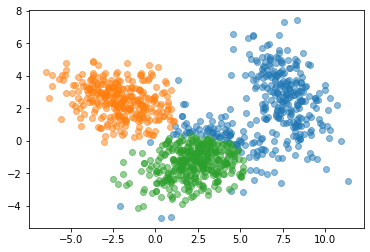

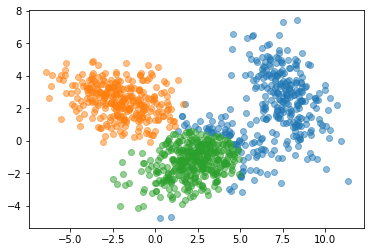

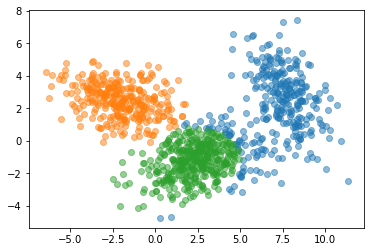

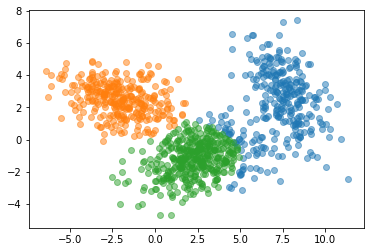

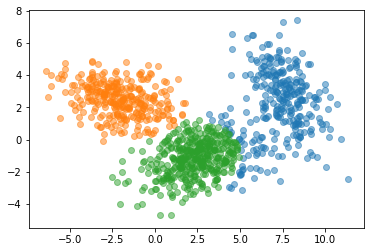

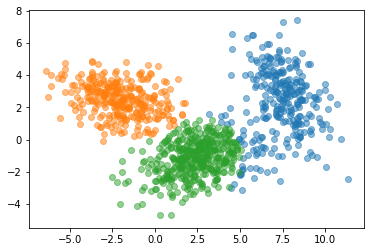

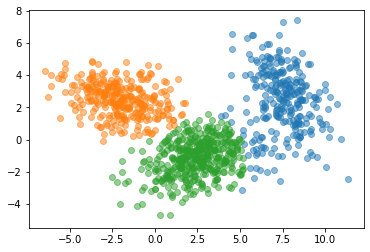

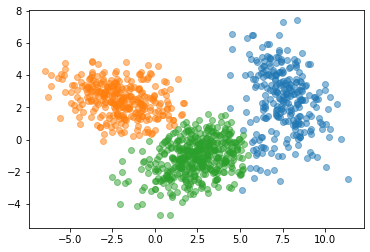

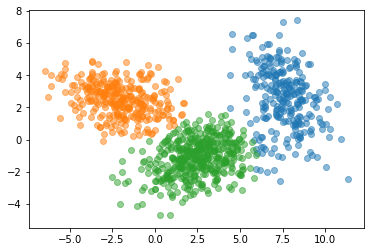

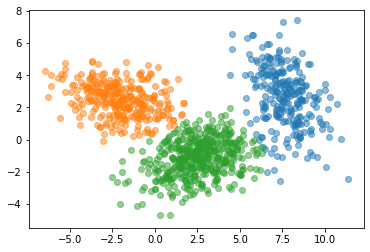

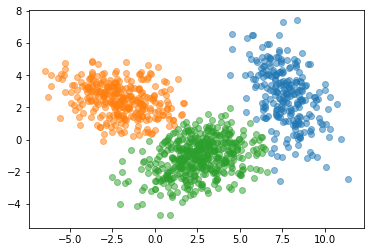

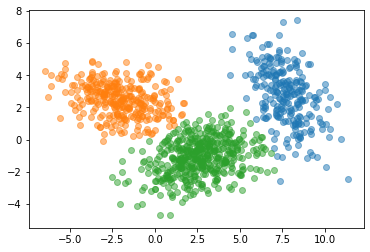

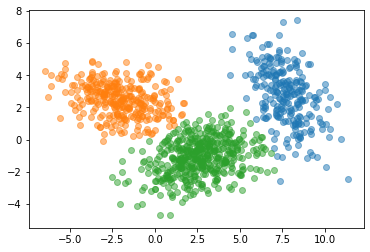

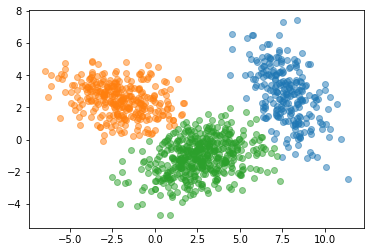

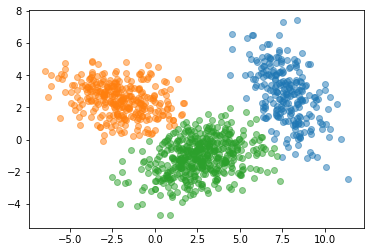

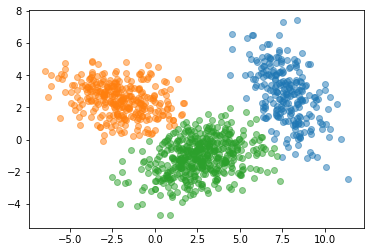

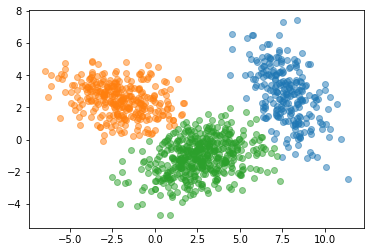

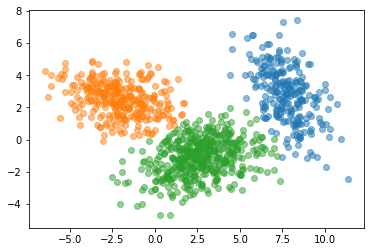

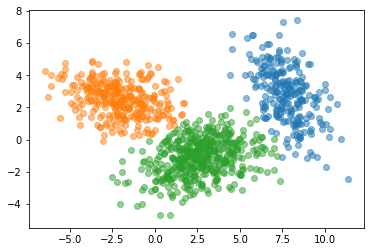

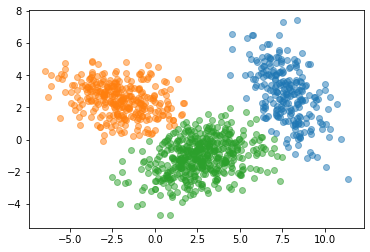

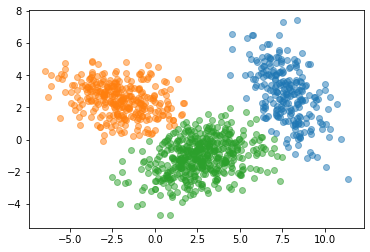

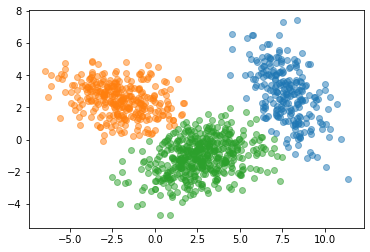

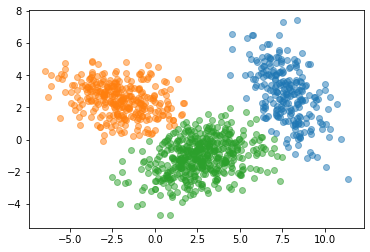

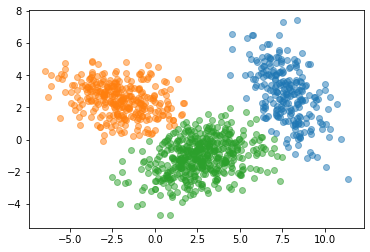

ended in epoch 27 7.560874109913129e-06
mean [[ 7.71701699  2.82337757]
 [-2.03694646  2.48029306]
 [ 2.66097599 -1.08538558]]
covariance [[[ 1.41515642 -1.03693117]
  [-1.03693117  3.13430293]]

 [[ 2.84566094 -0.5921191 ]
  [-0.5921191   1.12314696]]

 [[ 3.12129407  0.66956131]
  [ 0.66956131  1.36134557]]]
coefficient [0.24056573 0.29968109 0.45975318]


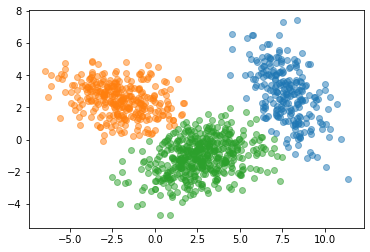

In [3]:
EM_callable = EM()
EM_callable.forward(1000,1e-5)